#  Reference: FDM Bayes Filtering
## Author
- **Name**: Azimov Sherkhon Azizkhon Ugli
- **Email**: sherkhonazim@gmail.com
- **GitHub**: @AzimovSherkhon

### Parameters:
- Method: Implicit Finite Difference Method (FDM) with Bayesian Inference for a double-well potential.
- Noise Strength: 0.9
- Domain Length: 2.0
- Spatial Points: 1024
- Time Step: 0.01
- Observation Noise (sigma): 0.2
- Observation Interval: Every 200 steps

In [1]:
import numpy as np
import matplotlib.pyplot as plt

observations = np.load("Obs_doublewell2_k_0.9.npy")
observation_times = np.load("Obs_time_doublewell2_k_0.9.npy")

In [2]:
def compute_posterior(obs, obs_noise_std, x_coords, prior_pdf):
    dx = x_coords[1] - x_coords[0]
    prior_pdf = prior_pdf / (np.sum(prior_pdf) * dx)
    log_prior = np.log(prior_pdf)
    log_likelihood = -((obs - x_coords) ** 2) / (2 * obs_noise_std ** 2)
    log_posterior = log_likelihood + log_prior
    unnormalized_posterior = np.exp(log_posterior)
    posterior = unnormalized_posterior / (np.sum(unnormalized_posterior) * dx)
    mean_posterior = np.sum(x_coords * posterior * dx)
    variance_posterior = np.sum((x_coords ** 2) * posterior * dx) - mean_posterior ** 2
    std_posterior = np.sqrt(variance_posterior)
    return posterior, mean_posterior, std_posterior

In [3]:
domain_length = 2.0
num_points = 1024
x_coords = np.linspace(-domain_length, domain_length, num_points)
spatial_step = x_coords[1] - x_coords[0]
time_step = 0.01
noise_strength = 0.9
diffusion_coeff = noise_strength**2 / 2
final_time = 50.0
total_steps = int(final_time / time_step)

initial_pdf = np.exp(-2 * x_coords**2 * (x_coords**2 - 2) / noise_strength**2)
initial_pdf /= np.sum(initial_pdf * spatial_step)

a = 1 - time_step * (12 * x_coords**2 - 4) + 2 * time_step * diffusion_coeff / spatial_step**2
b = -2 * time_step * x_coords * (x_coords**2 - 1) / spatial_step - time_step * diffusion_coeff / spatial_step**2
c = 2 * time_step * x_coords * (x_coords**2 - 1) / spatial_step - time_step * diffusion_coeff / spatial_step**2

A = np.zeros((num_points, num_points))
for j in range(num_points):
    A[j, j] = a[j]
for j in range(num_points - 1):
    A[j, j + 1] = b[j]
for j in range(1, num_points):
    A[j, j - 1] = c[j]

pdf_evolution = np.zeros((total_steps, num_points))
pdf_evolution[0] = initial_pdf
means = np.zeros(total_steps)
stds = np.zeros(total_steps)
means[0] = np.sum(x_coords * initial_pdf * spatial_step)
stds[0] = np.sqrt(np.sum(x_coords**2 * initial_pdf * spatial_step) - means[0]**2)

obs_noise_std = 0.2
obs_interval = 200
obs_idx = 1

current_pdf = initial_pdf.copy()
for t in range(1, total_steps):
    current_pdf = np.linalg.solve(A, current_pdf)
    current_pdf /= np.sum(current_pdf * spatial_step)
    means[t] = np.sum(x_coords * current_pdf * spatial_step)
    stds[t] = np.sqrt(np.sum(x_coords**2 * current_pdf * spatial_step) - means[t]**2)

    if t % obs_interval == 0 and obs_idx < len(observations):
        obs = observations[obs_idx]
        posterior, mean_posterior, std_posterior = compute_posterior(obs, obs_noise_std, x_coords, current_pdf)
        current_pdf = posterior
        means[t] = mean_posterior
        stds[t] = std_posterior
        obs_idx += 1

    pdf_evolution[t] = current_pdf

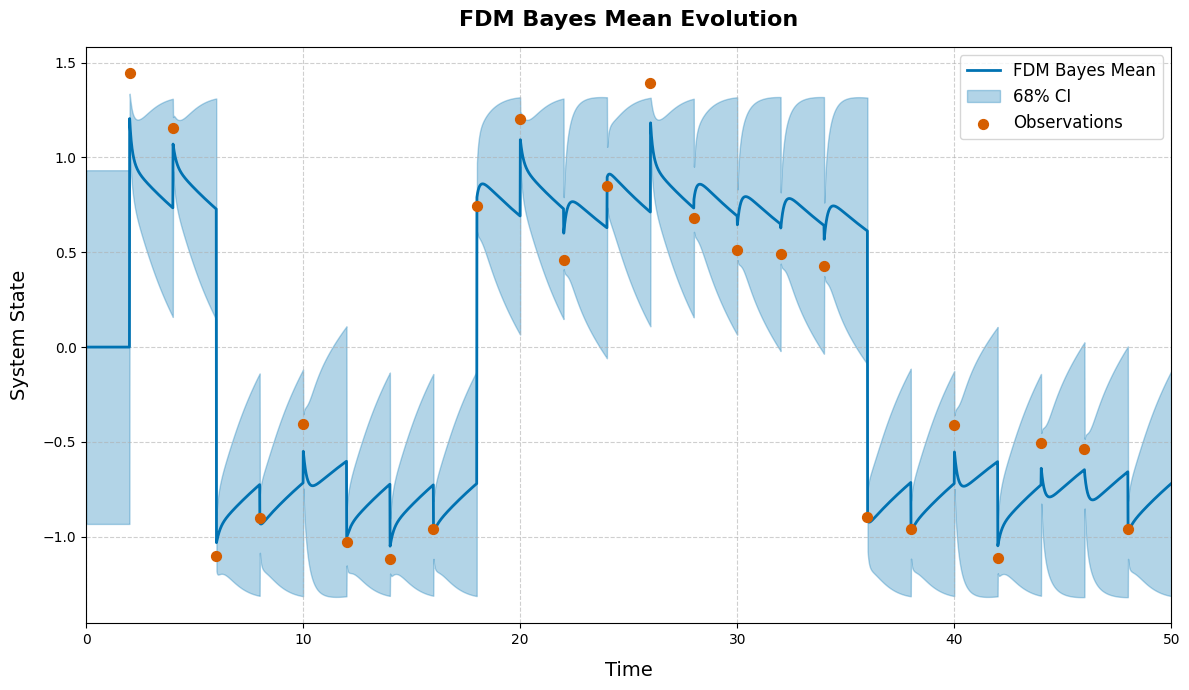

In [4]:
import matplotlib.pyplot as plt

time_coords = np.linspace(0, time_step * total_steps, total_steps)
plt.figure(figsize=(12, 7))
plt.plot(time_coords, means, label="FDM Bayes Mean", color="#0072B2", linewidth=2)
plt.fill_between(time_coords, means - stds, means + stds, color="#0072B2", alpha=0.3, label="68% CI")
plt.scatter(observation_times[1:50], observations[1:50], label="Observations", color="#D55E00", s=50, zorder=2)

plt.xlabel("Time", fontsize=14, labelpad=10)
plt.ylabel("System State", fontsize=14, labelpad=10)
plt.title("FDM Bayes Mean Evolution", fontsize=16, fontweight="bold", pad=15)
plt.legend(fontsize=12, loc="upper right", frameon=True)
plt.xlim(0, 50)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig("fdm_bayes_mean_2.png", dpi=300, bbox_inches="tight")
plt.show()

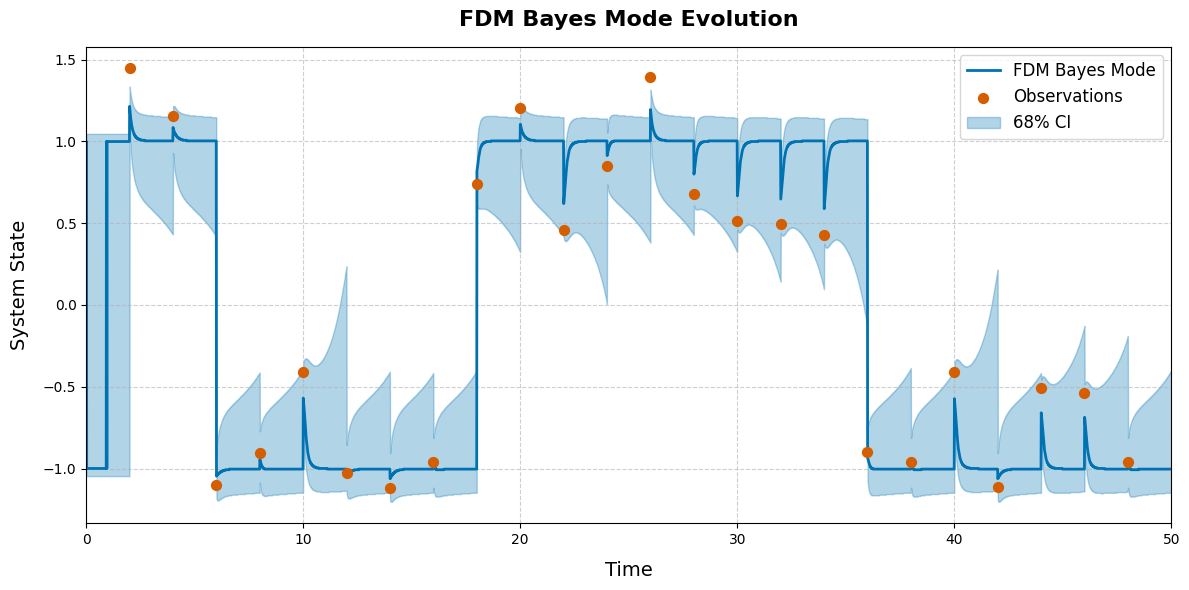

In [5]:
modes = x_coords[np.argmax(pdf_evolution, axis=1)]
cdf = np.cumsum(pdf_evolution, axis=1)
cdf /= cdf[:, -1][:, None]
lower_idx = np.argmax(cdf >= 0.16, axis=1)
upper_idx = np.argmax(cdf >= 0.84, axis=1)
lower_bounds = x_coords[lower_idx]
upper_bounds = x_coords[upper_idx]

plt.figure(figsize=(12, 6))
plt.plot(time_coords, modes, label="FDM Bayes Mode", color="#0072B2", linewidth=2)
plt.scatter(observation_times[1:50], observations[1:50], label="Observations", color="#D55E00", s=50, zorder=2)
plt.fill_between(time_coords, lower_bounds, upper_bounds, color="#0072B2", alpha=0.3, label="68% CI")

plt.xlabel("Time", fontsize=14, labelpad=10)
plt.ylabel("System State", fontsize=14, labelpad=10)
plt.title("FDM Bayes Mode Evolution", fontsize=16, fontweight="bold", pad=15)
plt.legend(fontsize=12, loc="upper right", frameon=True)
plt.xlim(0, 50)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig("fdm_bayes_mode_2.png", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
np.save("FDM_0_50_0.9_2.npy", pdf_evolution.T)
np.save("FDM_modes_0_50_0.9_2.npy", modes)